# Задача: Отобразить высокомерные данные $X ∈ ℝ^D$ в низкомерное пространство $Y ∈ ℝ^d (d=2,3)$ так, чтобы сохранить структуру соседства.

    1. Вероятностная постановка задачи


Задача: Отобразить высокомерные данные $X ∈ ℝ^D$ в низкомерное пространство $Y ∈ ℝ^d (d=2,3)$
так, чтобы сохранить структуру соседства.


        - Вероятности в исходном пространстве

Гауссово ядро для измерения сходства:

$
p_{j|i} = exp(-||x_i - x_j||^2 / (2σ_i^2)) / Σ_{k≠i} exp(-||x_i - x_k||^2 / (2σ_i^2))$

Симметризация вероятностей:

$
p_{ij} = (p_{j|i} + p_{i|j}) / (2n)$

Перплексия (perplexity) как гиперпараметр:

$
Perp(P_i) = 2^{H(P_i)}, $

где $H(P_i) = -Σ_j p_{j|i} log₂ p_{j|i}$

        - Вероятности в целевом пространстве

Распределение Стьюдента с одной степенью свободы:

$
q_{ij} = (1 + ||y_i - y_j||^2)^{-1} / Σ_{k≠l} (1 + ||y_k - y_l||^2)^{-1}$

Преимущества t-распределения:

       * Тяжелые хвосты

       * Устойчивость к проклятию размерности

       * Улучшенное разделение кластеров

       * Функция стоимости (KL-дивергенция)

$C(Y) = KL(P||Q) = Σ_i Σ_j p_{ij} log(p_{ij} / q_{ij})$

    2. Оптимизация функции стоимости

        2.1. Градиент функции стоимости

$∂C/∂y_i = 4 Σ_j (p_{ij} - q_{ij})(y_i - y_j)(1 + ||y_i - y_j||^2)^{-1}$

       2.2. Методы оптимизации

Градиентный спуск с моментумом:

$Y^{(t)} = Y^{(t-1)} + η ∂C/∂Y + α(t)(Y^{(t-1)} - Y^{(t-2)})$


Раннее преувеличение (early exaggeration):


$p_{ij} ← p_{ij} × 4 (первые 100 итераций)$


Адаптивное обучение (adaptive learning rate)

        2.3. Сложности оптимизации

            - Невыпуклость функции стоимости

            - Локальные минимумы

            - Чувствительность к начальной инициализации

            - Вычислительная сложность O(n²)

Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Задание

1. Провести исследование влияния гиперпараметров на результаты кластеризации с T-SNE
2. Сравнить с PCA
   
Использовать 2 датасета - стандартного типа Ирис или Цифры, и своего. Не забываем про нормировку и eda в целом

In [2]:
# путь к вашему файлу
path = "data/EEG-Eye-State.csv"  # замените на реальный путь

df = pd.read_csv(path)
df.head()


AF3      AF4       F3       F4       F7       F8      FC5      FC6  \
0  4329.23  4393.85  4289.23  4280.51  4009.23  4635.90  4148.21  4211.28   
1  4324.62  4384.10  4293.85  4279.49  4004.62  4632.82  4148.72  4207.69   
2  4327.69  4389.23  4295.38  4282.05  4006.67  4628.72  4156.41  4206.67   
3  4328.72  4396.41  4296.41  4287.69  4011.79  4632.31  4155.90  4210.77   
4  4326.15  4398.46  4292.31  4288.21  4011.79  4632.82  4151.28  4212.82   

        T7       T8       P7       P8       O1       O2  eyeDetection  
0  4350.26  4238.46  4586.15  4222.05  4096.92  4641.03             0  
1  4342.05  4226.67  4586.67  4210.77  4097.44  4638.97             0  
2  4336.92  4222.05  4583.59  4207.69  4096.92  4630.26             0  
3  4343.59  4235.38  4582.56  4217.44  4097.44  4630.77             0  
4  4347.69  4244.10  4586.67  4210.77  4095.90  4627.69             0

# Убираем выбросы в данных (как в лабораторной работе №1).

In [3]:
q = 0.999

feature_names = [x for x in df.columns if x != 'eyeDetection']
for feature in feature_names:
    df = df[df[feature] < df[feature].quantile(q)]
df

AF3      AF4       F3       F4       F7       F8      FC5      FC6  \
0      4329.23  4393.85  4289.23  4280.51  4009.23  4635.90  4148.21  4211.28   
1      4324.62  4384.10  4293.85  4279.49  4004.62  4632.82  4148.72  4207.69   
2      4327.69  4389.23  4295.38  4282.05  4006.67  4628.72  4156.41  4206.67   
3      4328.72  4396.41  4296.41  4287.69  4011.79  4632.31  4155.90  4210.77   
4      4326.15  4398.46  4292.31  4288.21  4011.79  4632.82  4151.28  4212.82   
...        ...      ...      ...      ...      ...      ...      ...      ...   
14975  4281.03  4340.51  4245.64  4269.23  3990.26  4593.33  4116.92  4171.28   
14976  4276.92  4333.33  4245.13  4259.49  3991.79  4590.26  4110.77  4162.56   
14977  4277.44  4339.49  4246.67  4257.95  3990.77  4591.79  4113.85  4160.51   
14978  4284.62  4350.77  4251.28  4267.18  3991.79  4596.41  4122.05  4165.64   
14979  4287.69  4350.77  4260.00  4274.36  3997.44  4597.95  4121.03  4167.69   

            T7       T8       P7       P8       O1       O2  eyeDetection  
0      4350.26  4238.46  4586.15  4222.05  4096.92  4641.03             0  
1      4342.05  4226.67  4586.67  4210.77  4097.44  4638.97             0  
2      4336.92  4222.05  4583.59  4207.69  4096.92  4630.26             0  
3      4343.59  4235.38  4582.56  4217.44  4097.44  4630.77             0  
4      4347.69  4244.10  4586.67  4210.77  4095.90  4627.69             0  
...        ...      ...      ...      ...      ...      ...           ...  
14975  4333.85  4221.54  4614.36  4203.08  4074.87  4625.64             1  
14976  4332.82  4217.44  4615.38  4194.36  4073.33  4621.54             1  
14977  4333.33  4212.82  4615.38  4193.33  4072.82  4623.59             1  
14978  4334.36  4220.00  4616.41  4200.00  4080.51  4628.72             1  
14979  4333.33  4226.67  4616.41  4212.31  4088.72  4638.46             1  

[14760 rows x 15 columns]

In [4]:
target_class_names_dict = {
    0: 'Closed',
    1: 'Open Eyes'
}
target_class_names_dict

{0: 'Closed', 1: 'Open Eyes'}

In [5]:
from sklearn.datasets import load_digits

# 1. Загрузка данных
digits = load_digits()
X_digits = digits.data
y_digits = digits.target

Разделить выборку на фичи и целевую переменную

In [6]:
target_feature = 'eyeDetection'

feature_cols = [x for x in df.columns if x != target_feature]
X = df[feature_cols].to_numpy()
y = df[target_feature].to_numpy()
y_labels = [target_class_names_dict[y_] for y_ in y]

print(X.shape, y.shape)


(14760, 14) (14760,)


Нормировка

In [7]:
scaler = StandardScaler()
X_digits_scaled = scaler.fit_transform(X_digits)
X_scaled = scaler.fit_transform(X)

# Мой датасет

Доля объяснённой дисперсии: [0.52430889 0.16607133] Суммарно: 0.6903802235062079


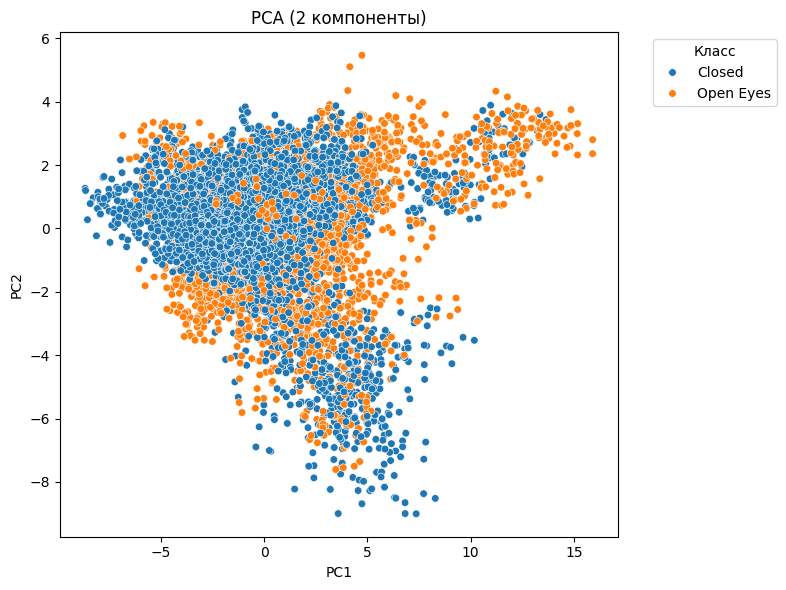

In [8]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("Доля объяснённой дисперсии:",  pca.explained_variance_ratio_ ,
      "Суммарно:", sum(pca.explained_variance_ratio_))

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_labels, palette="tab10", s=30)
plt.title("PCA (2 компоненты)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Класс", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Датасет digits

Доля объяснённой дисперсии: [0.12033916 0.09561054] Суммарно: 0.21594970500832794


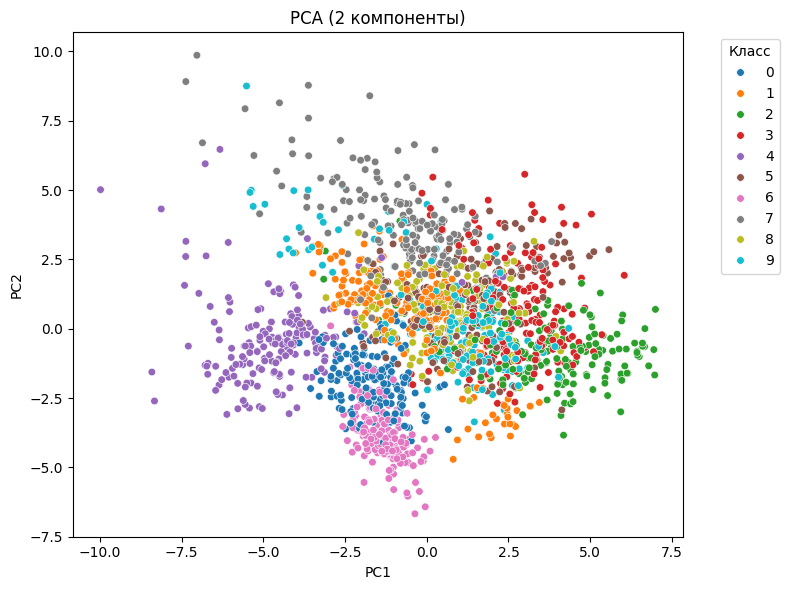

In [9]:
pca = PCA(n_components=2, random_state=42)
X_digits_pca = pca.fit_transform(X_digits_scaled)

print("Доля объяснённой дисперсии:",  pca.explained_variance_ratio_ ,
      "Суммарно:", sum(pca.explained_variance_ratio_))

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_digits_pca[:, 0], y=X_digits_pca[:, 1], hue=y_digits, palette="tab10", s=30)
plt.title("PCA (2 компоненты)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Класс", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

TSNE 2 компоненты

# Мой датасет

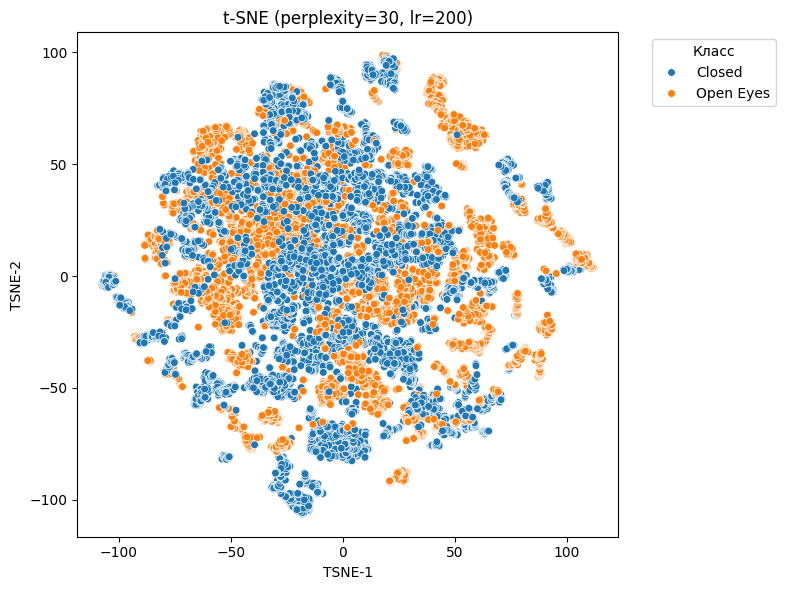

In [10]:
tsne = TSNE(
    n_components=2,
    random_state=42
)

X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_labels, palette="tab10", s=30)
plt.title("t-SNE (perplexity=30, lr=200)")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.legend(title="Класс", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


# Датасет digits

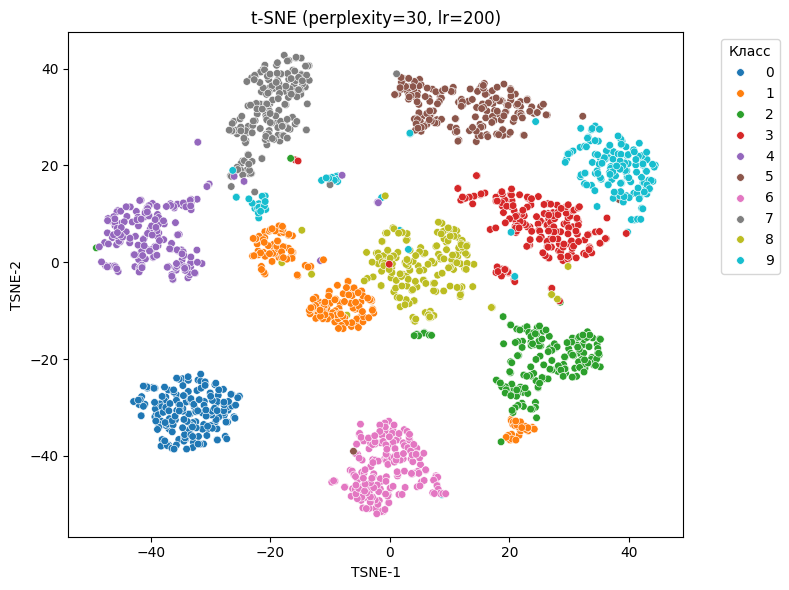

In [11]:
tsne = TSNE(
    n_components=2,
    random_state=42
)

X_digits_tsne = tsne.fit_transform(X_digits_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_digits_tsne[:, 0], y=X_digits_tsne[:, 1], hue=y_digits, palette="tab10", s=30)
plt.title("t-SNE (perplexity=30, lr=200)")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.legend(title="Класс", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Мой датасет

In [12]:
from sklearn.metrics import pairwise_distances

def separation_score(X_2d, y):
    D = pairwise_distances(X_2d)
    same = D[y[:, None] == y[None, :]]
    diff = D[y[:, None] != y[None, :]]
    return same.mean(), diff.mean(), diff.mean() / same.mean()

pca_same, pca_diff, pca_ratio = separation_score(X_pca, y)
tsne_same, tsne_diff, tsne_ratio = separation_score(X_tsne, y)

print("PCA:  среднее расстояние внутри класса =", pca_same,
      ", между классами =", pca_diff,
      ", ratio =", pca_ratio)
print("t-SNE: среднее расстояние внутри класса =", tsne_same,
      ", между классами =", tsne_diff,
      ", ratio =", tsne_ratio)


PCA:  среднее расстояние внутри класса = 3.4503607421165348 , между классами = 3.523129522874665 , ratio = 1.0210901949671187
t-SNE: среднее расстояние внутри класса = 81.73364 , между классами = 83.26809 , ratio = 1.0187738


# Датасет digits

In [13]:
pca_same, pca_diff, pca_ratio = separation_score(X_digits_pca, y_digits)
tsne_same, tsne_diff, tsne_ratio = separation_score(X_digits_tsne, y_digits)

print("PCA:  среднее расстояние внутри класса =", pca_same,
      ", между классами =", pca_diff,
      ", ratio =", pca_ratio)
print("t-SNE: среднее расстояние внутри класса =", tsne_same,
      ", между классами =", tsne_diff,
      ", ratio =", tsne_ratio)

PCA:  среднее расстояние внутри класса = 2.468234399163823 , между классами = 4.761456156687809 , ratio = 1.9290939945982737
t-SNE: среднее расстояние внутри класса = 12.108646 , между классами = 48.31301 , ratio = 3.9899597


Вычислить и отрисовать T-SNE с разным значением Perplexity

# Мой датасет

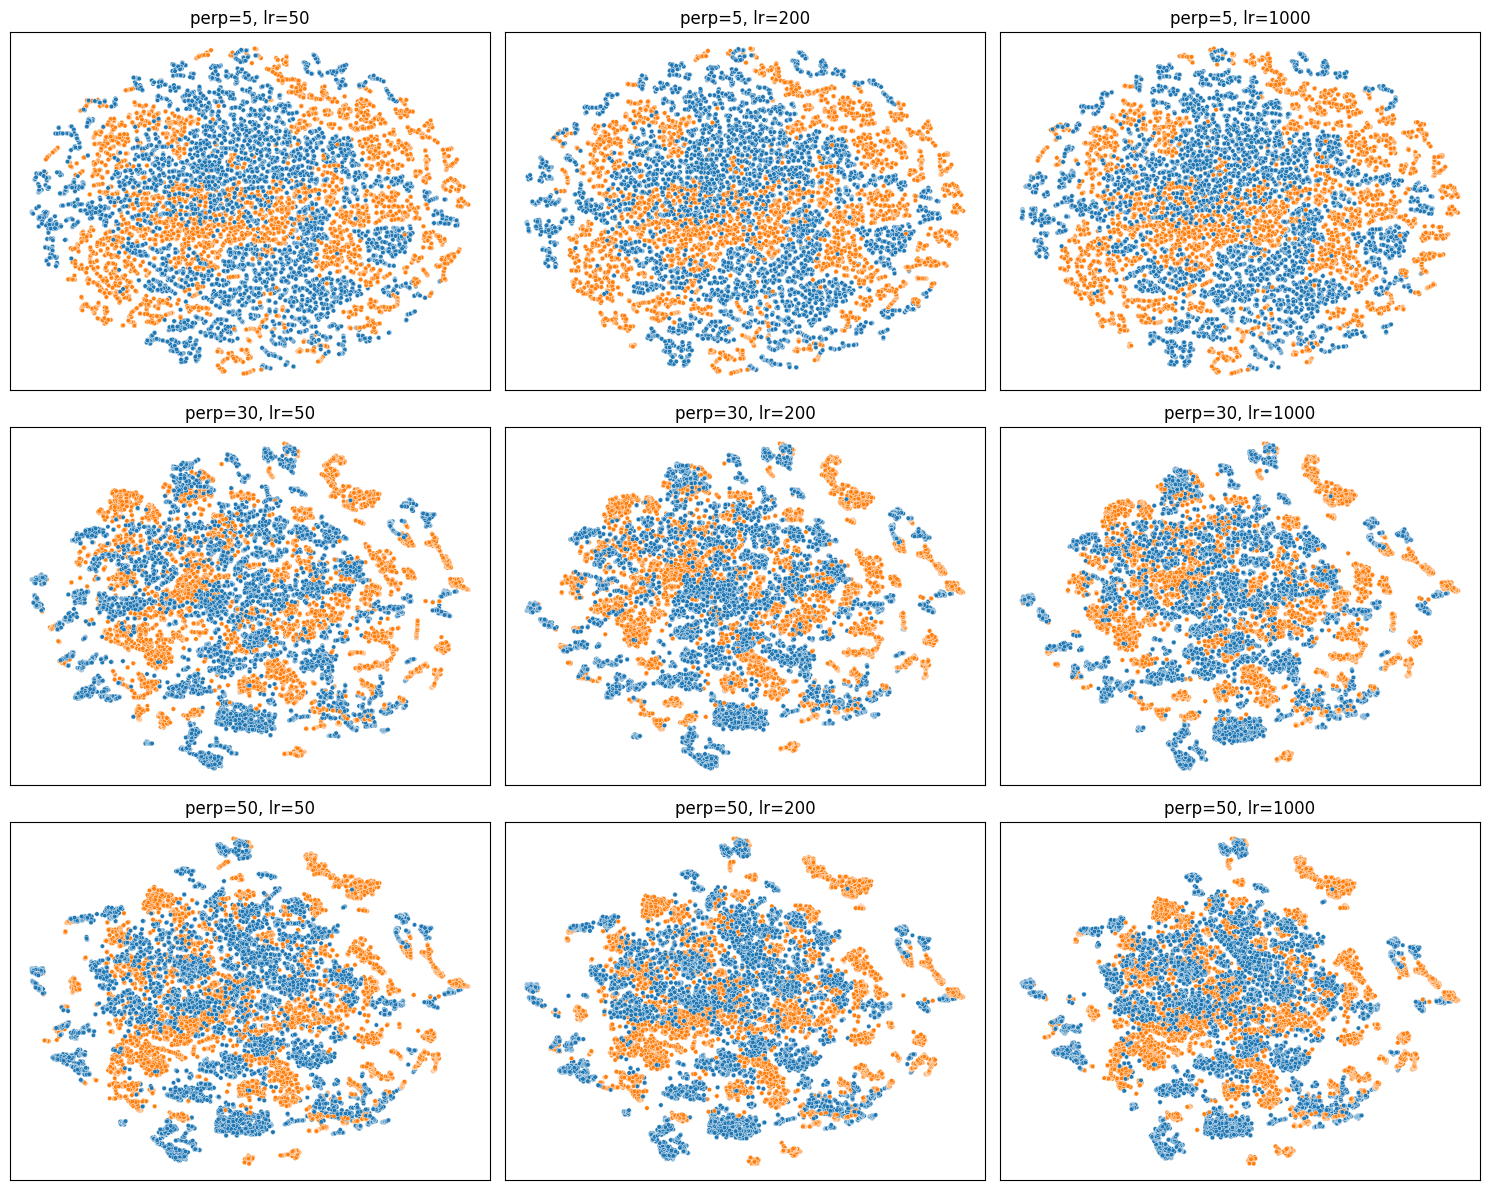

In [14]:
perplexities = [5, 30, 50]
learning_rates = [50, 200, 1000]

fig, axes = plt.subplots(len(perplexities), len(learning_rates),
                         figsize=(5*len(learning_rates), 4*len(perplexities)))

for i, perp in enumerate(perplexities):
    for j, lr in enumerate(learning_rates):
        tsne = TSNE(
            perplexity=perp,
            learning_rate=lr,
            random_state=42
        )
        X_emb = tsne.fit_transform(X_scaled)
        ax = axes[i, j]
        sns.scatterplot(x=X_emb[:, 0], y=X_emb[:, 1],
                        hue=y, palette="tab10", s=10, ax=ax, legend=False)
        ax.set_title(f"perp={perp}, lr={lr}")
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()


# Выводы:
* При больших параметрах perplexity появляется больше разных "облаков" классов
* При маленьких параметрах perplexity эти "облака" сливаются в один большой круг
* Параметр learning_rate практически никак не влияет на итоговую картину T-SNE

# Датасет digits

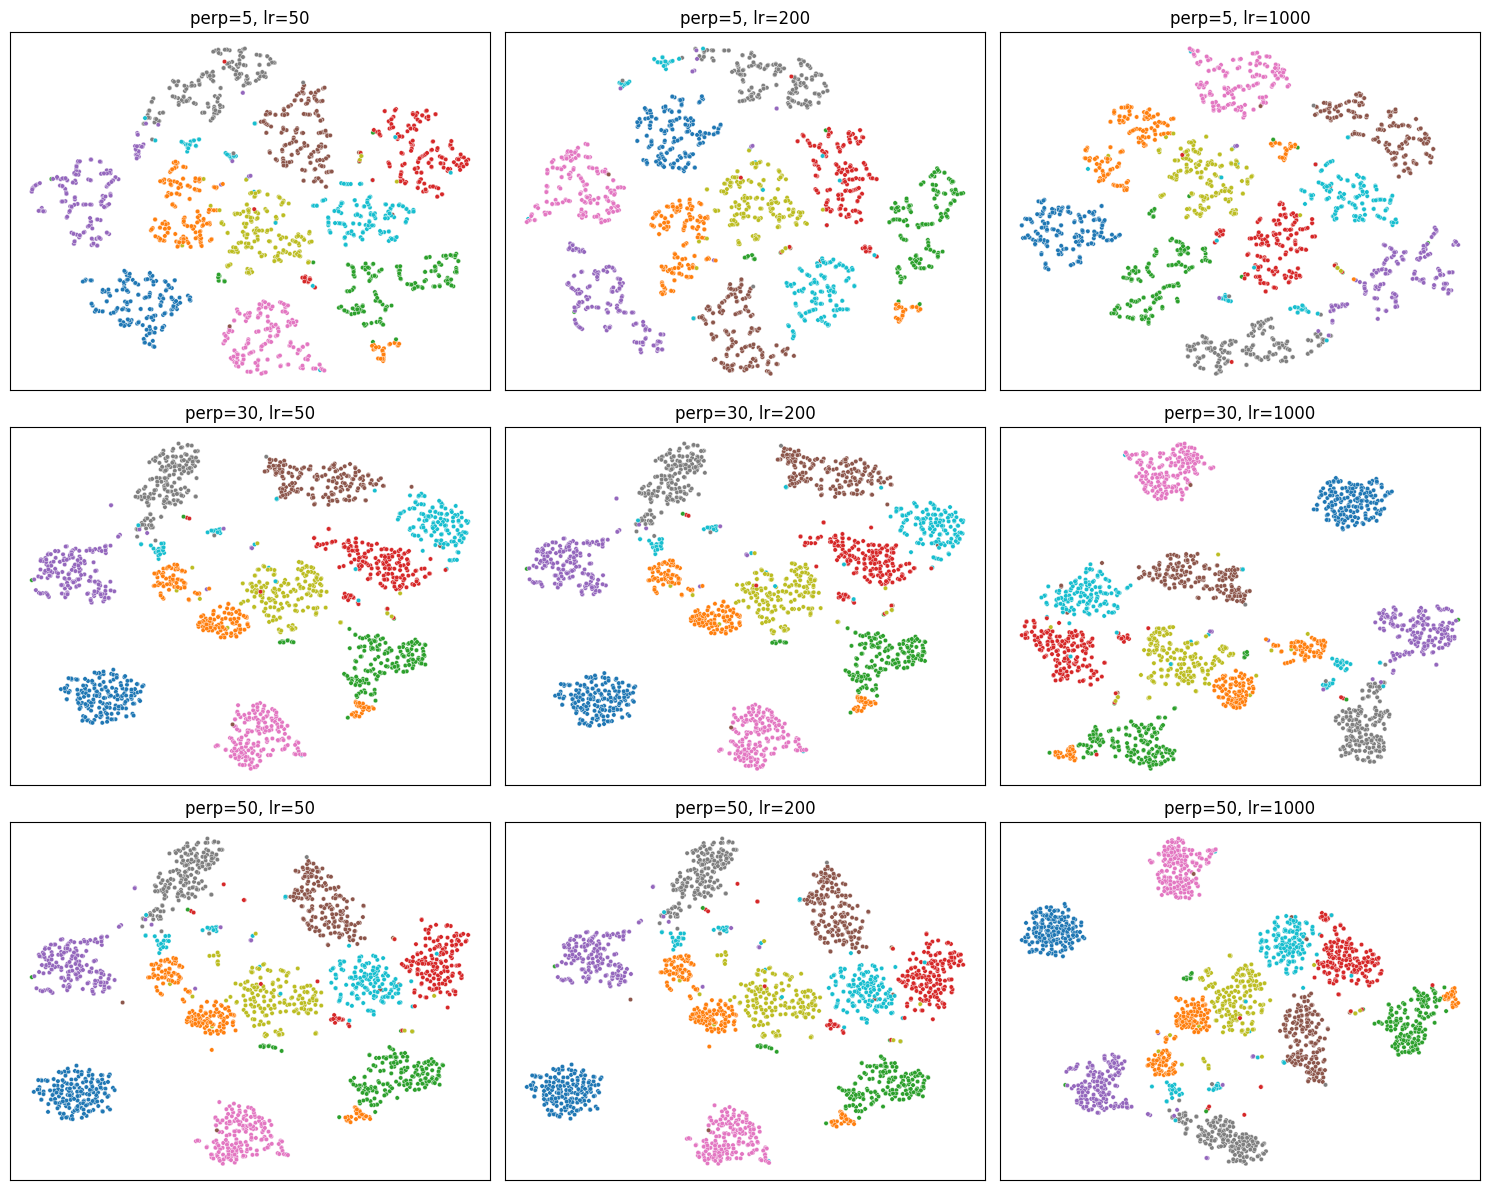

In [15]:
perplexities = [5, 30, 50]
learning_rates = [50, 200, 1000]

fig, axes = plt.subplots(len(perplexities), len(learning_rates),
                         figsize=(5*len(learning_rates), 4*len(perplexities)))

for i, perp in enumerate(perplexities):
    for j, lr in enumerate(learning_rates):
        tsne = TSNE(
            perplexity=perp,
            learning_rate=lr,
            random_state=42
        )
        X_emb = tsne.fit_transform(X_digits_scaled)
        ax = axes[i, j]
        sns.scatterplot(x=X_emb[:, 0], y=X_emb[:, 1],
                        hue=y_digits, palette="tab10", s=10, ax=ax, legend=False)
        ax.set_title(f"perp={perp}, lr={lr}")
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()


# Выводы:
* При маленьких значениях perplexity объекты в рамках одного кластерах находятся далеко друг от друга
* Параметр learning_rate очень сильно влияет на итоговую картину кластеров, но только при больших значениях (разницы между 50 и 200 практически нет, только некоторые кластеры меняются местами).
* Увеличие параметров learning_rate и perplexity, даже по отдельности, заметно увеличивает расстояния между кластерами разных классов.

Проанализируйте:

как меняется форма кластеров,

возникают ли “разрывы” или слияния при разных параметрах,

насколько стабилен рисунок при небольших изменениях параметров.

PCA: устойчивая структура
Для PCA параметров немного (по сути только число компонент), проекция при фиксированном random_state практически не меняется, что показывает устойчивость метода.

Можно показать, что при разных n_components (2, 3, больше) первые две компоненты остаются близкими, а общая структура мало меняется.

In [18]:
N_COMPONENTS = np.linspace(2, 10, 9, dtype=int)
N_COMPONENTS

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])

# Мой датасет

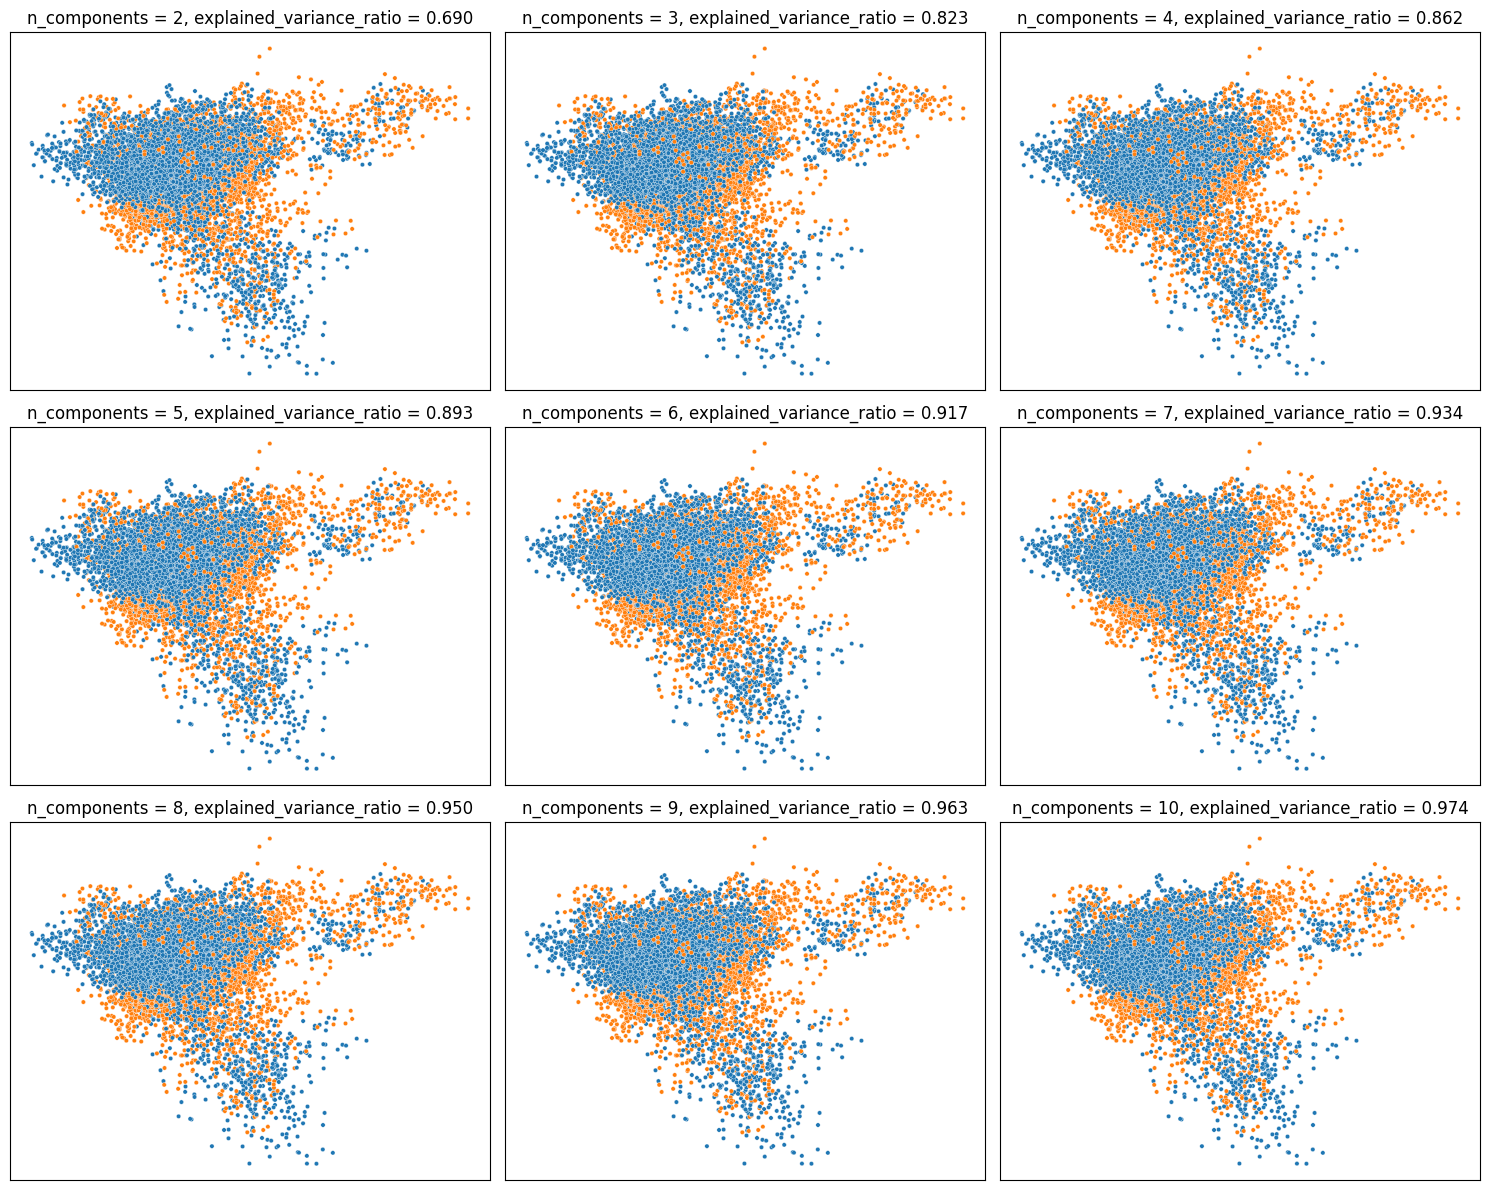

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

for i, n_comp in enumerate(N_COMPONENTS):
    pca = PCA(n_components=n_comp, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    ax = axes[i // 3, i % 3]
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],
                    hue=y_labels, palette="tab10", s=10, ax=ax, legend=False)
    ax.set_title(f"n_components = {n_comp}, explained_variance_ratio = {pca.explained_variance_ratio_.sum():.3f}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

# Датасет digits

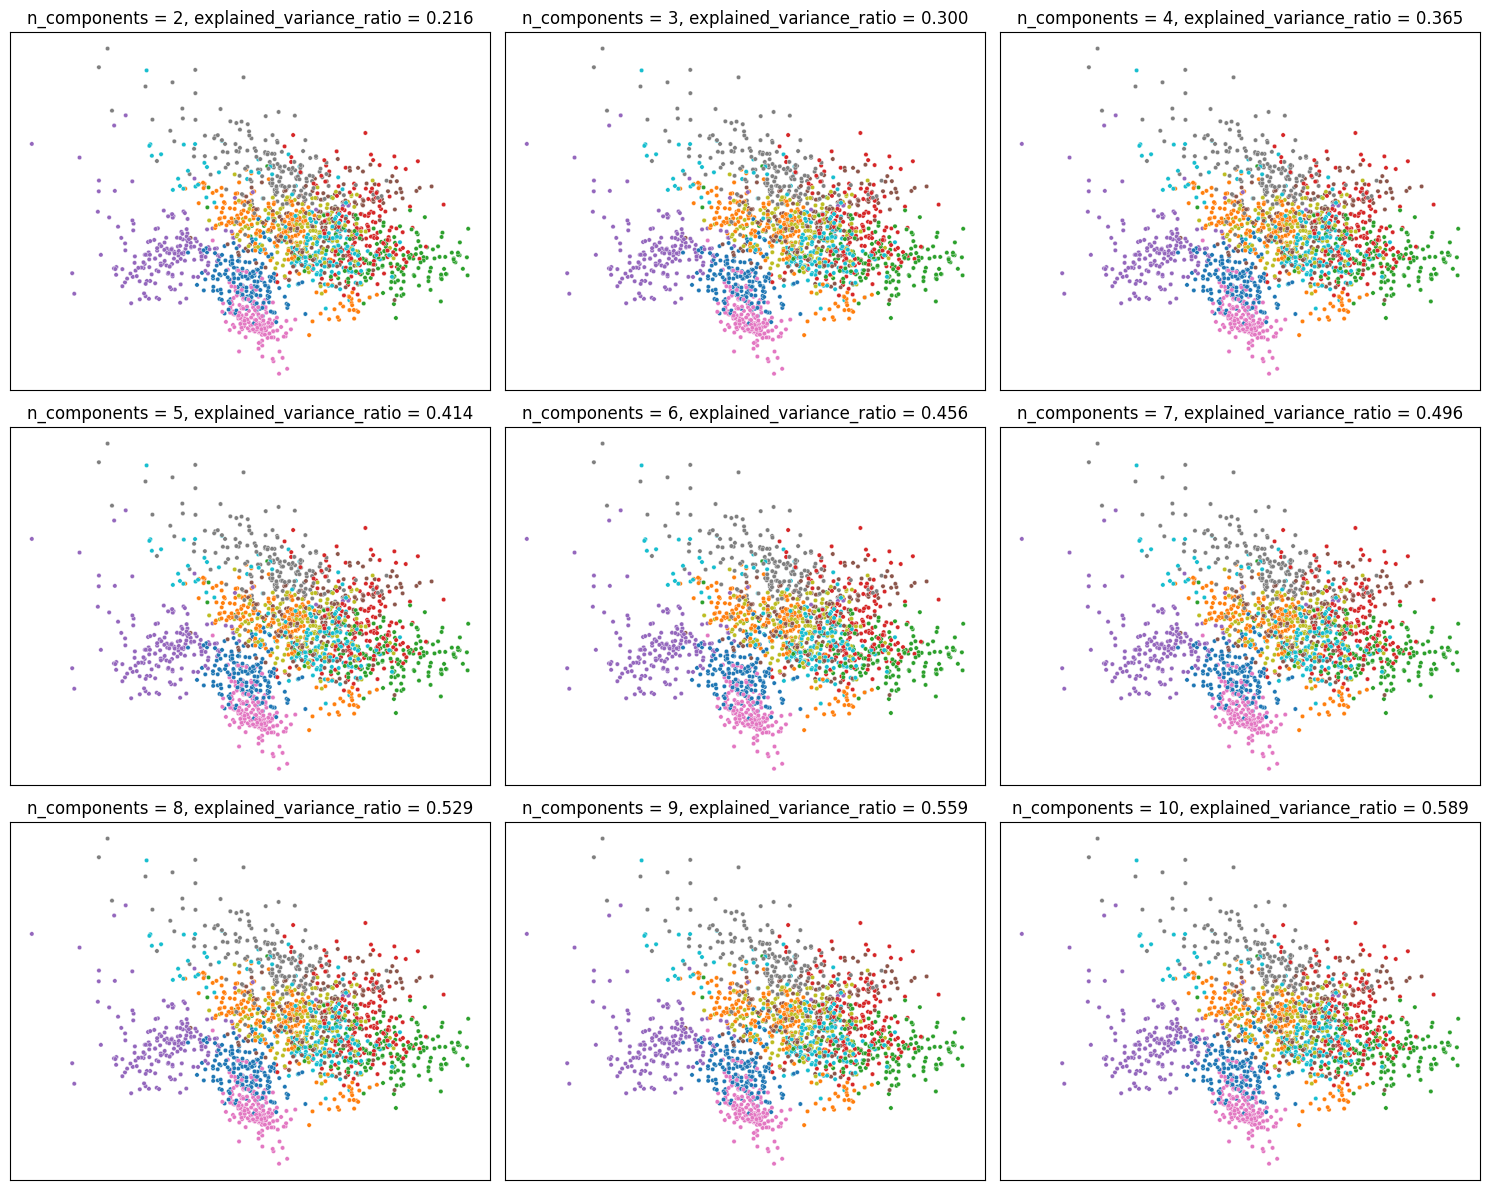

In [26]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

for i, n_comp in enumerate(N_COMPONENTS):
    pca = PCA(n_components=n_comp, random_state=42)
    X_digits_pca = pca.fit_transform(X_digits_scaled)
    ax = axes[i // 3, i % 3]
    sns.scatterplot(x=X_digits_pca[:, 0], y=X_digits_pca[:, 1],
                    hue=y_digits, palette="tab10", s=10, ax=ax, legend=False)
    ax.set_title(f"n_components = {n_comp}, explained_variance_ratio = {pca.explained_variance_ratio_.sum():.3f}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()